In [1]:
import pandas as pd

In [5]:
!wget https://huggingface.co/datasets/CortexLM/midjourney-v6/resolve/main/data/train-00000-of-00001.parquet

--2024-06-16 05:14:14--  https://huggingface.co/datasets/CortexLM/midjourney-v6/resolve/main/data/train-00000-of-00001.parquet
Resolving huggingface.co (huggingface.co)... 108.156.211.125, 108.156.211.90, 108.156.211.51, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.125|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/ac/97/ac974afa18fb23dd12e702d1412b67857532381117ef4b1508453efd1b3bb905/b47d979b7da3268847f8f09b1483fef18602848895ca57b3e0371d0de071bbde?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train-00000-of-00001.parquet%3B+filename%3D%22train-00000-of-00001.parquet%22%3B&Expires=1718774054&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxODc3NDA1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2FjLzk3L2FjOTc0YWZhMThmYjIzZGQxMmU3MDJkMTQxMmI2Nzg1NzUzMjM4MTExN2VmNGIxNTA4NDUzZWZkMWIzYmI5MDUvYjQ3ZDk3OWI3ZGEzMjY4ODQ

In [6]:
df = pd.read_parquet('train-00000-of-00001.parquet')

In [7]:
df

,prompt,image_url,timestamp
0,A young child is sitting on some pita bread ne...,https://f004.backblazeb2.com/file/sota-images/...,2024-04-25 07:25:25+00:00
1,"A baby is chewing on a lawn chair, while a dog...",https://f004.backblazeb2.com/file/sota-images/...,2024-04-25 07:24:06+00:00
2,That city skyline with a blow dryer a cord on it,https://f004.backblazeb2.com/file/sota-images/...,2024-04-25 07:23:29+00:00
3,A woman smiles as he looks upward,https://f004.backblazeb2.com/file/sota-images/...,2024-04-25 07:22:27+00:00
4,A woman with an umbrella,https://f004.backblazeb2.com/file/sota-images/...,2024-04-25 07:21:13+00:00
...,...,...,...
310257,A dog walking with a cat laying a video game,https://f004.backblazeb2.com/file/sota-images/...,2024-03-15 14:51:22+00:00
310258,Two men are enjoying the day somewhere,https://f004.backblazeb2.com/file/sota-images/...,2024-03-15 14:49:57+00:00
310259,A person with food is stacked with dvd's by a ...,https://f004.backblazeb2.com/file/sota-images/...,2024-03-15 14:48:41+00:00
310260,A man uses his computer while standing on his ...,https://f004.backblazeb2.com/file/sota-images/...,2024-03-15 14:47:13+00:00


In [36]:
import diffusers
import torch

pipe = diffusers.StableDiffusionPipeline.from_pretrained("Lykon/Dreamshaper").to('cuda', torch.float16)

vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:01,  3.30it/s]An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--Lykon--Dreamshaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--Lykon--Dreamshaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:01<00:03,  1.35it/s]An error occurred while trying to fetch /home/ubuntu/.cache/huggingface/hub/models--Lykon--Dreamshaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/ubuntu/.cache/huggingface/hub/models--Lykon--Dreamshaper/snapshots/228d79cb20811466f5c5710aa91f05dabd0b8a14/vae.

In [37]:
lats = {}

def hook(module, input, output):
    lats[input[1].item()] = (input[0], output[0])

pipe.unet.register_forward_hook(hook)

image = pipe("a funny dog")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 26.94it/s]


In [41]:
def get_pred_x0(xt, noise_pred, timestep, scheduler):
    if not isinstance(timestep, torch.Tensor):
        timestep = torch.tensor(timestep)#.to(xt.device)
    if len(timestep.shape) == 0:
        timestep = timestep[None]
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    beta_prod_t = 1 - alpha_prod_t
    pred_x0 = (xt - beta_prod_t[:,None,None,None].to(xt.device) ** (0.5) * noise_pred) / alpha_prod_t[:,None,None,None].to(xt.device) ** (0.5)
    return pred_x0

x0s = []
for t, v in lats.items():
    xt = v[0].chunk(2)[-1]
    pred_eps =v [1].chunk(2)[-1]
    pred_x0 = get_pred_x0(xt, pred_eps, t, pipe.scheduler)
    x0s.append(pred_x0)


In [45]:
from PIL import Image
import numpy as np

pixel_x0s = []
for x0 in x0s:
    img = pipe.vae.decode(x0.to(pipe.vae.dtype) / pipe.vae.config.scaling_factor).sample.cpu().detach().numpy()
    img = img.squeeze().transpose(1, 2, 0) / 2 + 0.5
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    pixel_x0s.append(img)



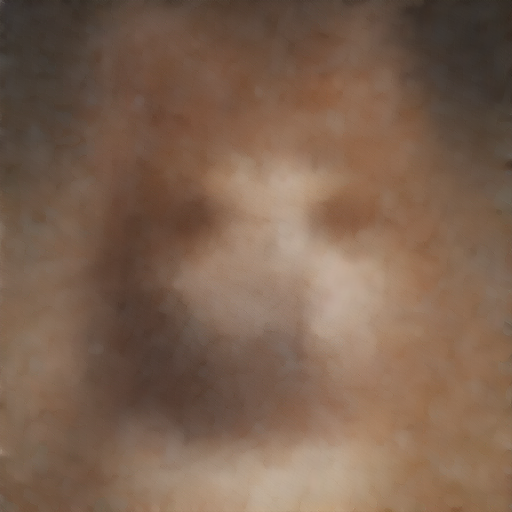

In [49]:
pixel_x0s[0]

In [1]:
import diffusers

vae = diffusers.AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", subfolder="vae")

/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-07-29 20:33:27.151458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other

In [5]:
from PIL import Image
import torch
import numpy as np

img = Image.open("../me.png")
img = img.resize((768, 768))

vae = vae.to('cuda', torch.float16)

with torch.no_grad():
    encoded = vae.encode(torch.tensor(np.array(img) / 127.5 - 1).permute(2, 0, 1).unsqueeze(0).to('cuda', torch.float16))

In [10]:
encoded.latent_dist.sample().mean()

tensor(0.0221, device='cuda:0', dtype=torch.float16)

In [3]:
import pygame
import random

# Initialize Pygame
pygame.init()

pygame 2.6.0 (SDL 2.28.4, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default


(4, 1)

In [5]:
# Load the background image
background = pygame.image.load('../me.png')
bg_rect = background.get_rect()

# Set up the display
screen = pygame.display.set_mode(bg_rect.size)

# Load the snowflake image
snowflake_img = pygame.image.load('../snowflake.png')
# Resize the snowflake image if needed
snowflake_img = pygame.transform.scale(snowflake_img, (20, 20))

In [6]:
class Snowflake:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.speed = random.randint(1, 3)
        self.angle = random.uniform(0, 360)
        self.rotation_speed = random.uniform(-1, 1)

    def fall(self):
        self.y += self.speed
        self.x += random.uniform(-0.5, 0.5)
        self.angle += self.rotation_speed

        if self.y > bg_rect.height:
            self.y = random.randint(-50, -10)
            self.x = random.randint(0, bg_rect.width)

In [7]:
snowflakes = [Snowflake(random.randint(0, bg_rect.width), random.randint(-50, -10)) for _ in range(100)]

In [8]:
clock = pygame.time.Clock()
running = True

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # Update snowflake positions
    for snowflake in snowflakes:
        snowflake.fall()

    # Draw the background
    screen.blit(background, (0, 0))

    # Draw snowflakes
    for snowflake in snowflakes:
        rotated_snowflake = pygame.transform.rotate(snowflake_img, snowflake.angle)
        screen.blit(rotated_snowflake, (int(snowflake.x), int(snowflake.y)))

    # Update the display
    pygame.display.flip()

    # Cap the frame rate
    clock.tick(60)

pygame.quit()

In [1]:
import diffusers

pipe = diffusers.StableDiffusionPipeline.from_pretrained("Lykon/Dreamshaper")#.to('cuda', torch.float16)

/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-06 00:56:14.010655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 00:56:14.820119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ubuntu/miniconda3/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be 

In [4]:
pipe.unet.conv_in.weight.shape[:2]

torch.Size([320, 4])